In [1]:
import torch
import lightning as L
from torch.nn import functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import BatchSizeFinder, LearningRateMonitor, ModelCheckpoint
from pytorch_lightning.loggers import NeptuneLogger
import neptune
import os

### Loading and PreProcessing the Data


txt to csv if needed

In [ ]:
# import csv

# name_open = 'Data.txt'
# name_new = 'datatest2.csv'
# delimiter = '|'  # Adjust this if your actual delimiter is different

# # Read from text file and write to CSV file
# with open(name_open, 'r') as f:
#     # Read the lines
#     lines = f.readlines()

# # Extract headers from the first line
# headers = [header.strip() for header in lines[0].split(delimiter)]

# # Open a new CSV file to write the data
# with open(name_new, 'w', newline='') as csvfile:
#     writer = csv.writer(csvfile, escapechar='\\')  # Specify escapechar to handle special characters
    
#     # Write headers
#     writer.writerow(headers)

#     # Write rows
#     for line in lines[1:]:
#         row = [item.strip() for item in line.split(delimiter)]
#         writer.writerow(row)

# print(f"Conversion completed. Data written to {name_new}")


csv to dataframe

In [2]:
df = pd.read_csv('data/Data2.csv' ,skiprows=1)

df_cleaned = df.dropna(axis=1, how='all')
print(f"Original shape: {df.shape}, Cleaned shape: {df_cleaned.shape}")

df_cleaned

Original shape: (7853, 661), Cleaned shape: (7853, 660)


,"f-act,_/sec","f-sim,_/sec","frame,_time","__cpu,_time","_gpu_,time_","_grnd,ratio","_flit,ratio","_real,_time","_totl,_time","missn,_time",...,"axis4,ratio","axis5,ratio","axis6,ratio","butn1,__sum","butn2,__sum","stick,ratio","gload,req_g","_C*__,____g","_elev,astab.1","_elev,_surf.1"
0,0.17733,19.90000,5.63906,0.00365,0.00223,1.0,1.0,65.12333,0.05025,0.05025,...,-0.01,-0.01,-0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.00007
1,0.19231,22.18968,5.20007,5.19611,0.02947,1.0,1.0,73.18698,0.14557,0.14557,...,-0.01,-0.01,-0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.00057
2,0.24159,21.38992,4.13920,-1.64632,11.65874,1.0,1.0,74.62391,0.24257,0.24257,...,-0.01,-0.01,-0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.00103
3,0.31458,22.31197,3.17882,-1.64632,11.65874,1.0,1.0,74.70666,0.32532,0.32532,...,-0.01,-0.01,-0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.00133
4,0.40920,24.08420,2.44381,-1.64632,11.65874,1.0,1.0,74.79237,0.41103,0.41103,...,-0.01,-0.01,-0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.00158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7848,21.21900,19.90000,0.04713,0.03325,0.05060,1.0,1.0,1014.02081,677.01807,671.60992,...,-0.01,-0.01,-0.01,0.0,0.0,0.0,0.0,0.0,-0.0,0.00963
7849,21.28282,19.90000,0.04699,0.03426,0.04488,1.0,1.0,1014.11407,677.11859,671.71039,...,-0.01,-0.01,-0.01,0.0,0.0,0.0,0.0,0.0,-0.0,0.01047
7850,20.65199,19.90000,0.04842,0.03426,0.04488,1.0,1.0,1014.21991,677.21912,671.81091,...,-0.01,-0.01,-0.01,0.0,0.0,0.0,0.0,0.0,-0.0,0.01132
7851,20.37985,19.90000,0.04907,0.03426,0.04488,1.0,1.0,1014.32275,677.31958,671.91138,...,-0.01,-0.01,-0.01,0.0,0.0,0.0,0.0,0.0,-0.0,0.01216


In [3]:
column_variances = df_cleaned.var() #calculating the variance of each coulmn

#calaculating the diffrences between each row and the one before it in order to find bad samples
df_time = df_cleaned['missn,_time']
df_time
time_diff = df_time.diff()
time_diff
max_time_diff = time_diff.max()
min_time_diff = time_diff.min()
avg_time_diff = time_diff.mean()
most_common_time_diff = time_diff.mode().iloc[0]

print(f'the max time difference is:{max_time_diff}, the min time difference is:{min_time_diff}, the average time difference is:{avg_time_diff} and the common is {most_common_time_diff}')

count_greater_then_given = (time_diff > 0.2).sum()

print(f"Number of time differences greater than 1: {count_greater_then_given}")


the max time difference is:0.15076000000004797, the min time difference is:-5.3091, the average time difference is:0.08558237901171677 and the common is 0.10050000000001091
Number of time differences greater than 1: 0


In [4]:
column_variances['_dewp,deg_C']

1.0289350180482089e-24

lets check the variance in all the data sets we currently having. features which got 0 variance in all the datasets we can probably drop

In [5]:
datas_tocheck = ['Data2','Data3','Data4','Data5','Data6']
common_zero_variance_features = None
for data in datas_tocheck:
    df1 = pd.read_csv(f'data/{data}.csv' ,skiprows=1)
    df1_cleaned = df1.dropna(axis=1, how='all')
    print(f"{data} Original shape: {df1.shape}, Cleaned shape: {df1_cleaned.shape}")
    variances = df1_cleaned.var()
    zero_variance_features = variances[variances==0].index.tolist()

    print(f'{data} got {len(zero_variance_features)} features which their variance is 0')

    if common_zero_variance_features is None:
        common_zero_variance_features = set(zero_variance_features)
    else:
        common_zero_variance_features = common_zero_variance_features.intersection(zero_variance_features)

common_zero_variance_features = list(common_zero_variance_features)
print("Common features with zero variance across all datasets:", common_zero_variance_features)
print(len(common_zero_variance_features))


    

Data2 Original shape: (7853, 661), Cleaned shape: (7853, 660)
Data2 got 346 features which their variance is 0
Data3 Original shape: (7423, 661), Cleaned shape: (7423, 660)
Data3 got 349 features which their variance is 0
Data4 Original shape: (8373, 661), Cleaned shape: (8373, 660)
Data4 got 347 features which their variance is 0
Data5 Original shape: (7630, 661), Cleaned shape: (7630, 660)
Data5 got 389 features which their variance is 0
Data6 Original shape: (8008, 661), Cleaned shape: (8008, 660)
Data6 got 408 features which their variance is 0
Common features with zero variance across all datasets: ['__GPU,__rat', '__map,range', 'deice,inlet', 'l-brk,___lb', '__low,_volt', '_wind,speed.1', 'engin,_in_W', 'aoa__,ice__.1', 'lwing,ice__', '__app,_____', 'alt_7,ftMSL', 'pitch,___lb', 'ADF_1,_freq', '__COM,__xmt', 'lbrak,__add', '_wind,_gust.2', '_wind,_gust.1', 'deice,pito2', '__APU,__amp', 'throt,__PFC', 'manul,ignit.1', '_roll,cycli', 'empty,___lb', '_mast,__war', '___ap,__src', '_f

In [6]:
df2 = pd.read_csv('data/Data2.csv', skiprows=1)
df2 = df2.dropna(axis=1, how='all')
print(f"df2 shape: {df2.shape}")
df2 = df2.drop(common_zero_variance_features, axis=1)
print(f"df2 shape: {df2.shape}")

df2

df2 shape: (7853, 660)
df2 shape: (7853, 330)


,"f-act,_/sec","f-sim,_/sec","frame,_time","__cpu,_time","_gpu_,time_","_real,_time","_totl,_time","missn,_time","_zulu,_time","local,_time",...,"____P,deg/s.1","____Q,deg/s.1","____R,deg/s.1","axis1,ratio","axis2,ratio","axis3,ratio","axis4,ratio","axis5,ratio","axis6,ratio","_elev,_surf.1"
0,0.17733,19.90000,5.63906,0.00365,0.00223,65.12333,0.05025,0.05025,20.24001,12.24001,...,0.55493,1.92931,0.03776,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,0.00007
1,0.19231,22.18968,5.20007,5.19611,0.02947,73.18698,0.14557,0.14557,20.24004,12.24004,...,0.83693,3.52315,0.05054,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,0.00057
2,0.24159,21.38992,4.13920,-1.64632,11.65874,74.62391,0.24257,0.24257,20.24007,12.24007,...,0.81550,3.86641,0.03269,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,0.00103
3,0.31458,22.31197,3.17882,-1.64632,11.65874,74.70666,0.32532,0.32532,20.24009,12.24009,...,0.68925,3.72370,0.01798,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,0.00133
4,0.40920,24.08420,2.44381,-1.64632,11.65874,74.79237,0.41103,0.41103,20.24011,12.24011,...,0.56480,3.39238,-0.05165,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,0.00158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7848,21.21900,19.90000,0.04713,0.03325,0.05060,1014.02081,677.01807,671.60992,20.42806,12.42806,...,-2.07101,0.81901,-2.86209,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,0.00963
7849,21.28282,19.90000,0.04699,0.03426,0.04488,1014.11407,677.11859,671.71039,20.42809,12.42809,...,-2.03263,0.84504,-2.90323,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,0.01047
7850,20.65199,19.90000,0.04842,0.03426,0.04488,1014.21991,677.21912,671.81091,20.42811,12.42811,...,-1.99276,0.87090,-2.94398,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,0.01132
7851,20.37985,19.90000,0.04907,0.03426,0.04488,1014.32275,677.31958,671.91138,20.42814,12.42814,...,-1.94237,0.89632,-2.98321,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,0.01216


In [ ]:
get_rid = ['f-act,_/sec','f-sim,_/sec','frame,_time','__cpu,_time','_gpu_,time_','_real,_time',]

In [39]:
test_csv = 'test_csv.csv'
df2.to_csv(test_csv,index=False)

NameError: name 'df2' is not defined

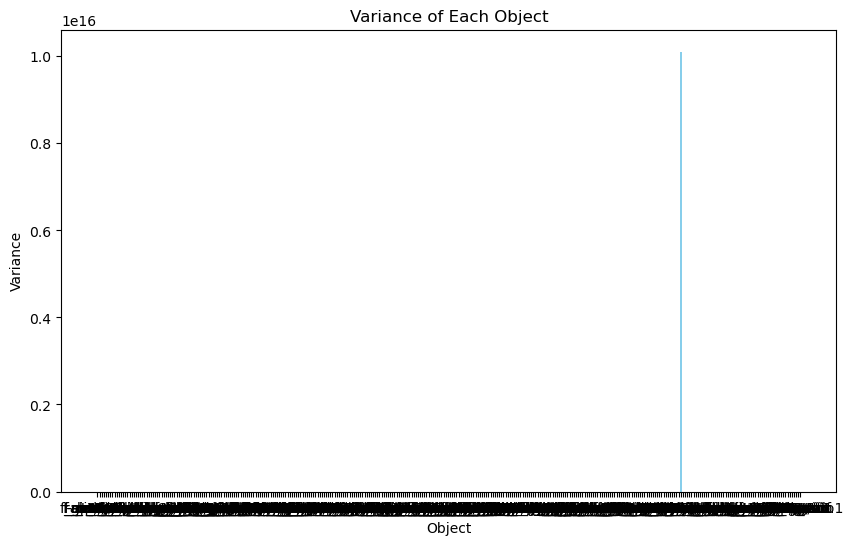

In [ ]:
column_variances = df2.var()
names = list(column_variances.keys())
variances = column_variances.tolist()

plt.figure(figsize=(10, 6))
plt.bar(names, variances, color='skyblue')

# Add title and labels
plt.title('Variance of Each Object')
plt.xlabel('Object')
plt.ylabel('Variance')

# Display the plot
plt.show()

               f-act,_/sec  f-sim,_/sec  frame,_time  __cpu,_time  \
f-act,_/sec       1.000000     0.231154    -0.492930    -0.464935   
f-sim,_/sec       0.231154     1.000000    -0.023000    -0.127930   
frame,_time      -0.492930    -0.023000     1.000000     0.251634   
__cpu,_time      -0.464935    -0.127930     0.251634     1.000000   
_gpu_,time_      -0.107040     0.075324     0.438006    -0.588746   
...                    ...          ...          ...          ...   
axis3,ratio            NaN          NaN          NaN          NaN   
axis4,ratio            NaN          NaN          NaN          NaN   
axis5,ratio            NaN          NaN          NaN          NaN   
axis6,ratio            NaN          NaN          NaN          NaN   
_elev,_surf.1    -0.087308    -0.151457     0.029554     0.059833   

               _gpu_,time_  _real,_time  _totl,_time  missn,_time  \
f-act,_/sec      -0.107040     0.016941     0.012177     0.012139   
f-sim,_/sec       0.075324    -0.

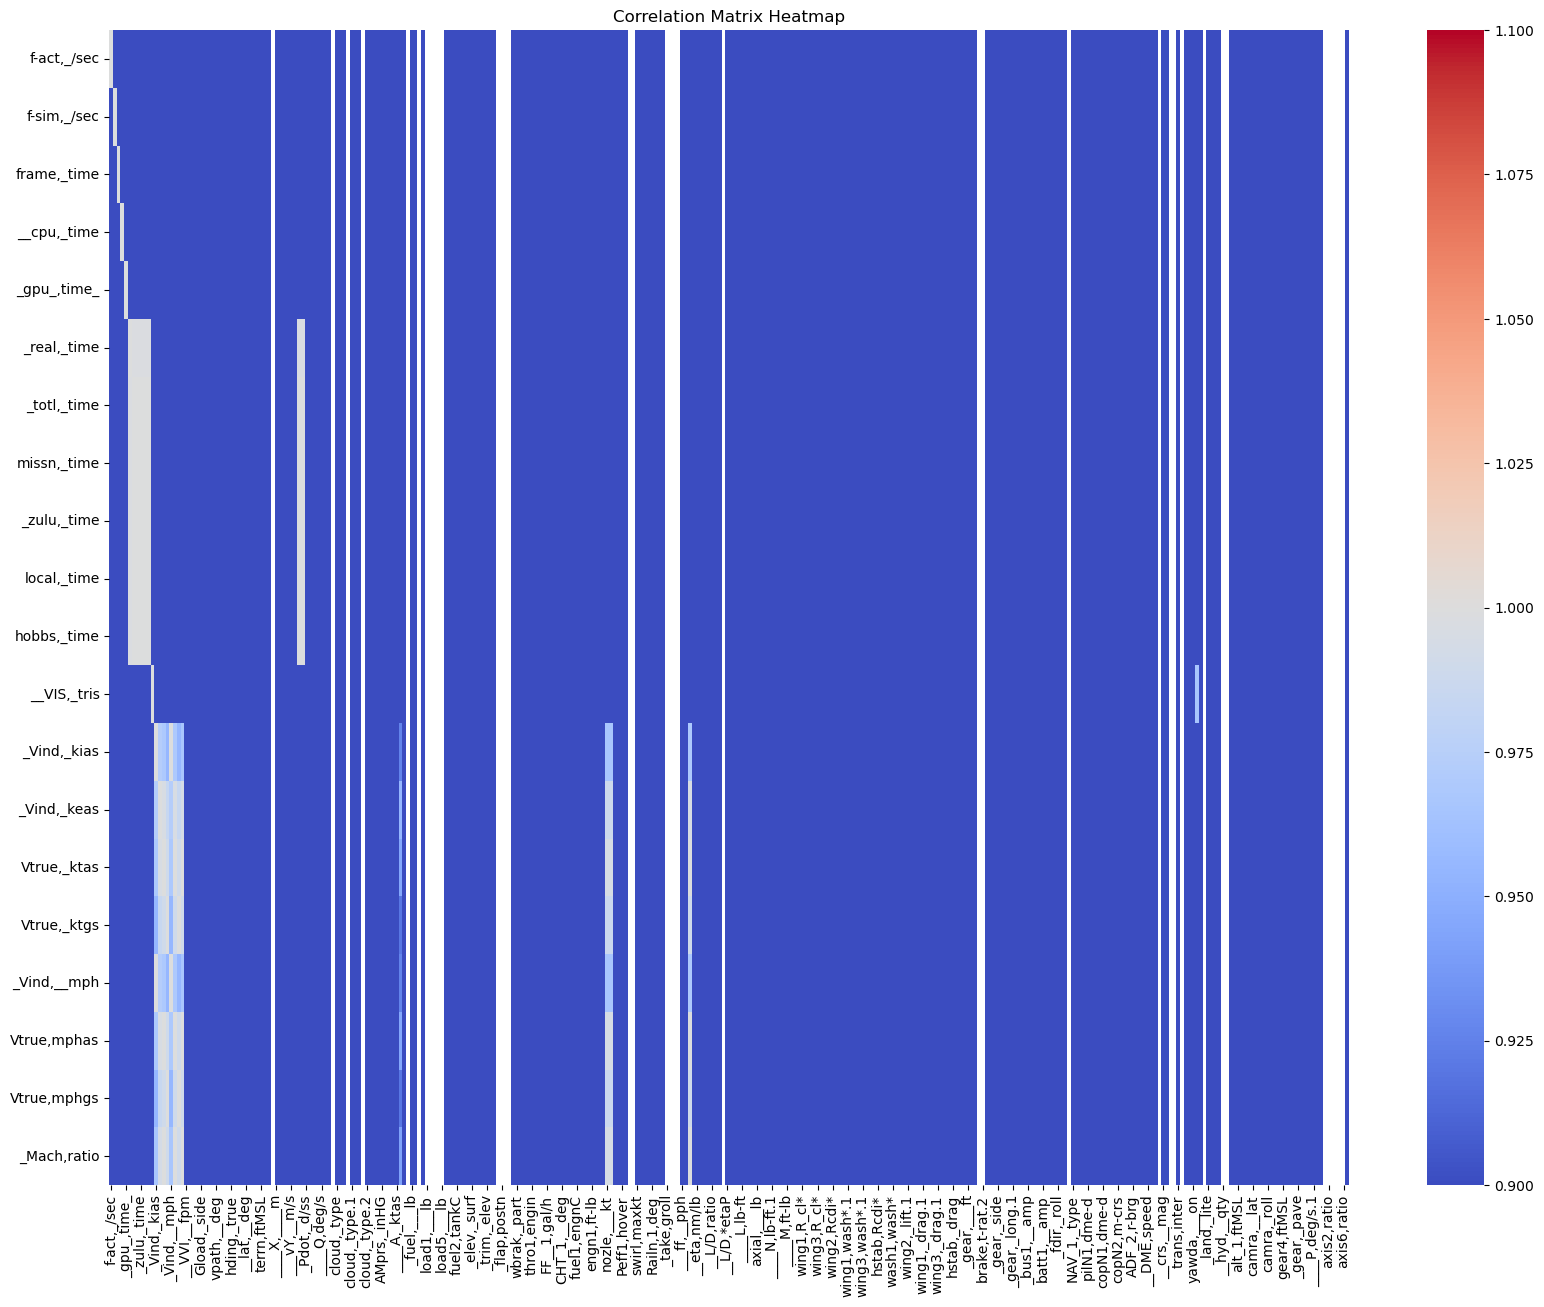

In [43]:
correlation_matrix = df2.corr()


# # Unstack the correlation matrix and sort by absolute correlation values
# correlation_series = correlation_matrix.abs().unstack().sort_values(ascending=False)

# # Remove duplicate pairs (self correlations and mirrored pairs)
# correlation_series = correlation_series[correlation_series < 1].drop_duplicates()

# # Extract the top correlations above a certain threshold (e.g., 0.9)
# threshold = 0.9
# high_correlations = correlation_series[correlation_series > threshold]

# # Print the features with high correlations
# print("Features with high correlations:")
# print(high_correlations)
print(correlation_matrix)
print(correlation_matrix.describe())

plt.figure(figsize=(20,15))
sns.heatmap(correlation_matrix[:20], cmap="coolwarm", vmin=1, vmax=1)

plt.title('Correlation Matrix Heatmap')
plt.show()

In [7]:
#relevent columes

relevent_features = ['_totl,_time','Vtrue,_ktgs','pitch,__deg','_roll,__deg','hding,_true','__lat,__deg','__lon,__deg','___CG,ftMSL','____X,____m','____Y,____m','____Z,____m','___vX,__m/s','___vY,__m/s','___vZ,__m/s'
                     ,'_elev,stick','ailrn,stick','ruddr,stick','thro1,engin'
]

train_data = pd.read_csv('data/Data2.csv', skiprows=1)
train_data = train_data.dropna(axis=1, how='all')
train_data = train_data[relevent_features]
train_data

val_data = pd.read_csv('data/Data3.csv', skiprows=1)
val_data = val_data.dropna(axis=1, how='all')
val_data = val_data[relevent_features]
val_data

test_data = pd.read_csv('data/Data4.csv', skiprows=1)
test_data = train_data.dropna(axis=1, how='all')
test_data = train_data[relevent_features]
test_data

,"_totl,_time","Vtrue,_ktgs","pitch,__deg","_roll,__deg","hding,_true","__lat,__deg","__lon,__deg","___CG,ftMSL","____X,____m","____Y,____m","____Z,____m","___vX,__m/s","___vY,__m/s","___vZ,__m/s","_elev,stick","ailrn,stick","ruddr,stick","thro1,engin"
0,0.05025,0.08962,2.50369,0.02244,92.61546,45.72394,-122.55013,292.82214,35021.74609,-56.05212,-24987.36914,-0.01215,0.05113,0.00660,0.00000,0.00000,0.00000,0.0
1,0.14557,0.13320,2.78831,0.09394,92.62069,45.72394,-122.55013,292.83615,35021.74219,-56.04783,-24987.36719,-0.06101,0.03080,0.01416,0.00000,0.00000,0.00000,0.0
2,0.24257,0.15175,3.15759,0.17618,92.62554,45.72394,-122.55013,292.83878,35021.73438,-56.04699,-24987.36719,-0.07731,-0.00651,0.01524,0.00000,0.00000,0.00000,0.0
3,0.32532,0.15559,3.47054,0.23833,92.62866,45.72394,-122.55013,292.83459,35021.72656,-56.04823,-24987.36523,-0.07660,-0.01822,0.01317,0.00000,0.00000,0.00000,0.0
4,0.41103,0.15037,3.77623,0.29061,92.62982,45.72394,-122.55013,292.82932,35021.72266,-56.04979,-24987.36523,-0.07464,-0.01758,0.00869,0.00000,0.00000,0.00000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7848,677.01807,102.64950,5.03510,-15.52756,92.21129,46.76450,-122.64340,10524.41309,27253.54688,3081.13818,-29478.54102,52.76324,2.18193,2.32113,0.01481,-0.03281,-0.00584,1.0
7849,677.11859,102.61120,5.03769,-15.75969,91.90834,46.76450,-122.64333,10525.20117,27258.84961,3081.35693,-29478.32422,52.75458,2.17173,2.05556,0.01505,-0.03179,-0.00577,1.0
7850,677.21912,102.57314,5.04044,-15.98804,91.60071,46.76449,-122.64326,10525.98730,27264.15039,3081.57471,-29478.13281,52.74484,2.16175,1.78573,0.01529,-0.03097,-0.00570,1.0
7851,677.31958,102.53516,5.04336,-16.21258,91.28848,46.76449,-122.64320,10526.76953,27269.45117,3081.79126,-29477.96875,52.73388,2.15198,1.51168,0.01552,-0.02800,-0.00564,1.0


# CREATING A MODEL

In [8]:
# class FlightDataset(Dataset):
#     def __init__(self, df, seq_len):
#         # Keeping only the relevant features

#         relevent_features = ['_totl,_time','Vtrue,_ktgs','pitch,__deg','_roll,__deg','hding,_true','__lat,__deg','__lon,__deg','___CG,ftMSL','____X,____m','____Y,____m','____Z,____m','___vX,__m/s','___vY,__m/s','___vZ,__m/s'
#                      ,'_elev,stick','ailrn,stick','ruddr,stick','thro1,engin']
        
#         self.df = df[relevent_features].copy()  # Use copy to avoid modifying the original DataFrame

#         # Changing the names of the features for easier use
#         self.df.columns = ['time', 'vt', 'pitch', 'roll', 'hding', 'lat', 'lon', 'alt', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'elev_stick', 'ailrn_stick', 'ruddr_stick', 'throttle']
        
#         # Instantiate the StandardScaler
#         self.scaler = StandardScaler()
        
#         # Fit and transform the data
#         self.df = pd.DataFrame(self.scaler.fit_transform(self.df), columns=relevent_features)
        
#         # Define sequence length
#         self.seq_len = seq_len

#     def __len__(self):
#         # Making the length shorter by seq_len so we always have a next_state
#         return len(self.df) - self.seq_len

#     def __getitem__(self, idx):
#         # Current state is the sequence of states from idx to idx + seq_len
#         current_state = self.df.iloc[idx:idx + self.seq_len].values.astype(float)
#         # Next state is the state at idx + seq_len
#         next_state = self.df.iloc[idx + self.seq_len][['lat', 'lon', 'alt', 'pitch', 'roll', 'hding', 'vx', 'vy', 'vz']].values.astype(float)

#         return torch.tensor(current_state, dtype=torch.float32), torch.tensor(next_state, dtype=torch.float32)
    
#     def inverse_transform(self, data):
#         return self.scaler.inverse_transform(data)
    
class FlightDataset(Dataset):
    def __init__(self, df, seq_len):
        # Keeping only the relevant features
        relevant_features = ['_totl,_time', 'Vtrue,_ktgs', 'pitch,__deg', '_roll,__deg', 'hding,_true', '__lat,__deg', '__lon,__deg', '___CG,ftMSL', '____X,____m', '____Y,____m', '____Z,____m', '___vX,__m/s', '___vY,__m/s', '___vZ,__m/s', '_elev,stick', 'ailrn,stick', 'ruddr,stick', 'thro1,engin']
        
        self.df = df[relevant_features].copy()  # Use copy to avoid modifying the original DataFrame

        # Changing the names of the features for easier use
        self.df.columns = ['time', 'vt', 'pitch', 'roll', 'hding', 'lat', 'lon', 'alt', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'elev_stick', 'ailrn_stick', 'ruddr_stick', 'throttle']
        
        # Instantiate the StandardScaler
        self.scaler = StandardScaler()
        
        # Fit and transform the data
        self.df = pd.DataFrame(self.scaler.fit_transform(self.df), columns=self.df.columns)
        
        # Define sequence length
        self.seq_len = seq_len

    def __len__(self):
        # Making the length shorter by seq_len so we always have a next_state
        return len(self.df) - self.seq_len

    def __getitem__(self, idx):
        # Current state is the sequence of states from idx to idx + seq_len
        current_state = self.df.iloc[idx:idx + self.seq_len].values.astype(float)
        # Next state is the state at idx + seq_len
        next_state = self.df.iloc[idx + self.seq_len][['lat', 'lon', 'alt', 'pitch', 'roll', 'hding', 'vx', 'vy', 'vz']].values.astype(float)

        return torch.tensor(current_state, dtype=torch.float32), torch.tensor(next_state, dtype=torch.float32)
    
    def inverse_transform(self, data):
        return self.scaler.inverse_transform(data)


In [15]:
class FlightLSTM(pl.LightningModule):
    def __init__(self,input_dim,hidden_dim,num_layers,output_dim,lr=0.001):
        super(FlightLSTM,self).__init__()
        self.lstm = nn.LSTM(input_dim,hidden_dim,num_layers,batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.lr = lr
        self.criterion = nn.MSELoss(reduction='none')

        self.training_step_outputs = []
        self.validation_step_outputs = []
        self.test_step_outputs = []
        
    def forward(self,x):
        out,_ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out
    
    def compute_metrics(self, y_true, y_pred):
        mse = np.mean((y_true - y_pred) ** 2, axis=0)
        mae = np.mean(np.abs(y_true - y_pred), axis=0)
        return mse, mae
    
    def training_step(self,batch,batch_idx):
        x, y = batch
        output = self(x)
        loss = self.criterion(output, y).mean()
        self.log("train/batch/loss", loss, prog_bar=False)

        y_true = y.cpu().detach().numpy()
        y_pred = output.cpu().detach().numpy()

        mse, mae = self.compute_metrics(y_true, y_pred)

        for i, feature in enumerate(['lat', 'lon', 'alt', 'pitch', 'roll', 'hding', 'vx', 'vy', 'vz']):
            self.log(f"train/batch/mse_{feature}", mse[i], prog_bar=False)
            self.log(f"train/batch/mae_{feature}", mae[i], prog_bar=False)

        self.training_step_outputs.append({"loss": loss, "mse": mse, "mae": mae, "y_true": y_true, "y_pred": y_pred})

        return {"loss": loss, "mse": mse, "mae": mae}
    
    def on_train_epoch_end(self):
        loss = np.array([output["loss"].detach().cpu().numpy() for output in self.training_step_outputs])
        mse = np.vstack([output["mse"] for output in self.training_step_outputs])
        mae = np.vstack([output["mae"] for output in self.training_step_outputs])

        y_true_all = np.vstack([output["y_true"] for output in self.training_step_outputs])
        y_pred_all = np.vstack([output["y_pred"] for output in self.training_step_outputs])

        mse_all = np.mean(mse, axis=0)
        mae_all = np.mean(mae, axis=0)
        r2_all = r2_score(y_true_all, y_pred_all)

        self.log("train/epoch/loss", loss.mean())  # Log training epoch loss
        for i, feature in enumerate(['lat', 'lon', 'alt', 'pitch', 'roll', 'hding', 'vx', 'vy', 'vz']):
            self.log(f"train/epoch/mse_{feature}", mse_all[i])  # Log training epoch MSE for each feature
            self.log(f"train/epoch/mae_{feature}", mae_all[i])  # Log training epoch MAE for each feature
        self.log("train/epoch/r2", r2_all)  # Log training epoch R²

        print("Training Epoch End: Loss:", loss.mean(), "MSE:", mse_all, "MAE:", mae_all, "R²:", r2_all)  # Debugging print
    

    def validation_step(self, batch, batch_idx):
        x, y = batch
        output = self(x)
        loss = self.criterion(output, y).mean()

        y_true = y.cpu().detach().numpy()
        y_pred = output.cpu().detach().numpy()

        mse, mae = self.compute_metrics(y_true, y_pred)

        for i, feature in enumerate(['lat', 'lon', 'alt', 'pitch', 'roll', 'hding', 'vx', 'vy', 'vz']):
            self.log(f"val/batch/mse_{feature}", mse[i], prog_bar=False)
            self.log(f"val/batch/mae_{feature}", mae[i], prog_bar=False)

        self.validation_step_outputs.append({"loss": loss, "mse": mse, "mae": mae, "y_true": y_true, "y_pred": y_pred})

        return {"loss": loss, "mse": mse, "mae": mae}
    
    def on_validation_epoch_end(self):
        loss = np.array([output["loss"].detach().cpu().numpy() for output in self.validation_step_outputs])
        mse = np.vstack([output["mse"] for output in self.validation_step_outputs])
        mae = np.vstack([output["mae"] for output in self.validation_step_outputs])

        y_true_all = np.vstack([output["y_true"] for output in self.validation_step_outputs])
        y_pred_all = np.vstack([output["y_pred"] for output in self.validation_step_outputs])

        mse_all = np.mean(mse, axis=0)
        mae_all = np.mean(mae, axis=0)
        r2_all = r2_score(y_true_all, y_pred_all)

        self.log("val/epoch/loss", loss.mean())  # Log validation epoch loss
        for i, feature in enumerate(['lat', 'lon', 'alt', 'pitch', 'roll', 'hding', 'vx', 'vy', 'vz']):
            self.log(f"val/epoch/mse_{feature}", mse_all[i])  # Log validation epoch MSE for each feature
            self.log(f"val/epoch/mae_{feature}", mae_all[i])  # Log validation epoch MAE for each feature
        self.log("val/epoch/r2", r2_all)  # Log validation epoch R²

        print("Validation Epoch End: Loss:", loss.mean(), "MSE:", mse_all, "MAE:", mae_all, "R²:", r2_all)  # Debugging print

        self.validation_step_outputs.clear()  # free memory

    def test_step(self, batch, batch_idx):
        x, y = batch
        output = self(x)
        loss = self.criterion(output, y).mean()

        y_true = y.cpu().detach().numpy()
        y_pred = output.cpu().detach().numpy()

        mse, mae = self.compute_metrics(y_true, y_pred)

        for i, feature in enumerate(['lat', 'lon', 'alt', 'pitch', 'roll', 'hding', 'vx', 'vy', 'vz']):
            self.log(f"test/batch/mse_{feature}", mse[i], prog_bar=False)
            self.log(f"test/batch/mae_{feature}", mae[i], prog_bar=False)

        self.test_step_outputs.append({"loss": loss, "mse": mse, "mae": mae, "y_true": y_true, "y_pred": y_pred})

        return {"loss": loss, "mse": mse, "mae": mae}

    def on_test_epoch_end(self):
        loss = np.array([output["loss"].detach().cpu().numpy() for output in self.test_step_outputs])
        mse = np.vstack([output["mse"] for output in self.test_step_outputs])
        mae = np.vstack([output["mae"] for output in self.test_step_outputs])

        y_true_all = np.vstack([output["y_true"] for output in self.test_step_outputs])
        y_pred_all = np.vstack([output["y_pred"] for output in self.test_step_outputs])

        mse_all = np.mean(mse, axis=0)
        mae_all = np.mean(mae, axis=0)
        r2_all = r2_score(y_true_all, y_pred_all)

        self.log("test/epoch/loss", loss.mean())  # Log test epoch loss
        for i, feature in enumerate(['lat', 'lon', 'alt', 'pitch', 'roll', 'hding', 'vx', 'vy', 'vz']):
            self.log(f"test/epoch/mse_{feature}", mse_all[i])  # Log test epoch MSE for each feature
            self.log(f"test/epoch/mae_{feature}", mae_all[i])  # Log test epoch MAE for each feature
        self.log("test/epoch/r2", r2_all)  # Log test epoch R²

        print("Test Epoch End: Loss:", loss.mean(), "MSE:", mse_all, "MAE:", mae_all, "R²:", r2_all)  # Debugging print

        self.test_step_outputs.clear()  # free memory
        
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.lr)
        return optimizer
    



In [35]:
class BaselineModel(pl.LightningModule):
    def __init__(self):
        super(BaselineModel, self).__init__()

    def forward(self, x):
        # Predict the next state to be the same as the current state
        return x[:, -1, :]

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = torch.nn.functional.mse_loss(y_hat, y)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = torch.nn.functional.mse_loss(y_hat, y)
        self.log('val_loss', loss)
        return loss
    
    

    def configure_optimizers(self):
        # Return a dummy optimizer
        return torch.optim.SGD(self.parameters(), lr=0.1)

In [16]:
sequance_length = 10
train_dataset = FlightDataset(train_data, sequance_length)
val_dataset = FlightDataset(val_data, sequance_length)
test_dataset = FlightDataset(test_data, sequance_length)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [17]:
neptune_logger = NeptuneLogger(
    api_key="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI0YTk3YWUxOS1lOWY2LTQ4NzUtOTMzMC00MDExYzA0N2UwNzAifQ==",
    project="peridan/PINN1",
    tags=["notebook"],
    log_model_checkpoints=False
)

In [18]:
input_dim = len(train_data.columns)
hidden_dim = 128
num_layers = 2
output_dim = 9
model = FlightLSTM(input_dim, hidden_dim, num_layers, output_dim)
trainer = pl.Trainer(
    logger = neptune_logger,
    max_epochs=10
    )
trainer.fit(model, train_loader, val_loader)
trainer.test(model, test_loader)
neptune_logger.experiment.stop()


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/peridan/PINN1/e/PIN-10


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | lstm      | LSTM    | 207 K  | train
1 | fc        | Linear  | 1.2 K  | train
2 | criterion | MSELoss | 0      | train
----------------------------------------------
209 K     Trainable params
0         Non-trainable params
209 K     Total params
0.836     Total estimated model params size (MB)


Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 35.81it/s]Validation Epoch End: Loss: 0.53087544 MSE: [0.58167565 1.5035915  1.6655539  0.01345096 0.02664996 0.50816447
 0.4018439  0.04824269 0.02870536] MAE: [0.76266754 1.2262074  1.2905439  0.11566643 0.16322158 0.7128513
 0.6339115  0.21962035 0.16942583] R²: -3822761667966.2725
                                                                           

c:\Users\ADMIN\anaconda3\envs\PinnProject\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\ADMIN\anaconda3\envs\PinnProject\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 246/246 [00:05<00:00, 45.34it/s, v_num=N-10]Validation Epoch End: Loss: 1.143263 MSE: [1.113197   2.203264   0.66967195 0.6544341  1.0480484  1.0357225
 1.5541627  0.6644348  1.3464305 ] MAE: [0.7813252  1.3089191  0.6789165  0.65660733 0.6972369  0.8570313
 1.0900565  0.5217178  0.90563154] R²: -0.14177994660601526
Epoch 0: 100%|██████████| 246/246 [00:10<00:00, 23.79it/s, v_num=N-10]Training Epoch End: Loss: 0.6798267 MSE: [0.57192445 0.30072114 0.451374   0.7877284  1.0571135  0.40113074
 0.59583324 0.97190154 0.9807115 ] MAE: [0.23914215 0.30363786 0.2941886  0.43509588 0.56424284 0.39534515
 0.5197378  0.40679446 0.56375957] R²: 0.3085301799194167
Epoch 1: 100%|██████████| 246/246 [00:05<00:00, 45.19it/s, v_num=N-10]Validation Epoch End: Loss: 0.8164017 MSE: [0.5654577  2.065565   0.83278847 0.5639953  0.8389669  0.49741432
 0.19293489 0.75872356 1.0317695 ] MAE: [0.59735155 1.2396066  0.7722585  0.5370086  0.7479159  0.5599157
 0.31468353 0.4747303  0.85

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 246/246 [00:10<00:00, 23.09it/s, v_num=N-10]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\ADMIN\anaconda3\envs\PinnProject\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 246/246 [00:05<00:00, 46.95it/s]Test Epoch End: Loss: 0.20043601 MSE: [0.14225744 0.17597568 0.13504596 0.18117455 0.60268563 0.10734599
 0.13286494 0.21027268 0.11630129] MAE: [0.23415124 0.29276967 0.24207963 0.27859455 0.6638311  0.2408049
 0.27759454 0.29031336 0.2655274 ] R²: 0.7956794339292544
Testing DataLoader 0: 100%|██████████| 246/246 [00:05<00:00, 46.55it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   test/batch/mae_alt       0.2429213523864746
  test/batch/mae_hding      0.24154174327850342
   test/batch/mae_lat        0.234578937292099
   test/batch/mae_lon       0.2935981750488281
  test/batch/mae_pitch      0.2785364091396332
   test/batch/mae_roll      0.6640021204948425
    test/batch/mae_

In [37]:
baseline_model = BaselineModel()

# Initialize the trainer
trainer = pl.Trainer(max_epochs=10)

# Train the model
trainer.fit(baseline_model, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


ValueError: optimizer got an empty parameter list